## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from src.data import DataLoader
from src.trainer import Trainer
from src.optimizers import SGD

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Preprocessing

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoader(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoader(X_val, y_val, batch_size=256, shuffle=False)

## Softmax from Scratch

In [4]:
# Create a tensor for testing
x = torch.randn(10, 5)  # A 2D tensor with batch size of 10 and 5 features

def softmax(X):
    # Compute the exponential of each element in the input tensor X
    X_exp = torch.exp(X)
    # Compute the sum of exponential values along each row, keeping the same dimensions
    sum_exp = X_exp.sum(axis=1, keepdims=True)
    # Divide each element in X_exp by the sum_exp to get the softmax probabilities
    return X_exp / sum_exp


# Apply the custom softmax function
custom_softmax_results = softmax(x)

# Apply PyTorch's softmax function
pytorch_softmax_results = F.softmax(x, dim=-1)

# Check if the results are close
are_close = torch.allclose(custom_softmax_results, pytorch_softmax_results)

print(f"Are the custom softmax and PyTorch softmax results close? {are_close}")

Are the custom softmax and PyTorch softmax results close? True


## Cross Entropy from Scratch

In [5]:
import torch
import torch.nn.functional as F

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, y_pred, y_true):
        num_classes = y_pred.size(1)
        y_one_hot = nn.functional.one_hot(y_true, num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

# Create tensors for testing
predictions = F.softmax(torch.randn(10, 5), dim=1)  # Random predictions (already passed through softmax)
targets = torch.tensor([1, 0, 4, 1, 3, 2, 2, 1, 0, 4])  # Random true classes

# Apply the custom cross-entropy function
cross_entropy = CrossEntropyLoss()
custom_loss = cross_entropy(predictions, targets)

# Apply PyTorch's cross-entropy function
# Note: PyTorch's cross-entropy loss combines log_softmax and nll_loss in a single function,
# so we pass the logits (predictions before softmax) to it.
pytorch_loss = F.cross_entropy(torch.log(predictions), targets)  # Using log(predictions) as a proxy for logits

# Check if the results are close
are_close = torch.allclose(custom_loss, pytorch_loss, atol=1e-6)

print(f"Are the custom cross-entropy and PyTorch cross-entropy results close? {are_close}")


Are the custom cross-entropy and PyTorch cross-entropy results close? True


## Logistic Regression From Scratch

### Simple Training Loop

In [7]:
num_samples = X_train.shape[0]
num_classes = y_train.unique().shape[0]
batch_size = 64

# Initialize W, it should be shape (num_features, num_classes) because it will 
# transform the input (num_examples, num_features) to the output (num_examples, num_classes)
W = torch.randn(size=(X_train.shape[1], num_classes), requires_grad=True)
# Initialize b, it should be shape (1, 1) because it will be a scalar we add to each class 
# prediction for each example
b = torch.zeros(num_classes, requires_grad=True)

parameters = [W, b]
optimizer = SGD(parameters, lr=0.1)
cross_entropy = CrossEntropyLoss()

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass (training)
        O = X_batch @ W + b
        y_pred = F.softmax(O)
        
        # Calculate Loss
        loss = cross_entropy(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

C:\Users\woute\AppData\Local\Temp\ipykernel_12716\1084198965.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(O)


2.21075564270958
0.04088406531893193
0.017243139818310736


### Define Training Loop and Model

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.W = torch.randn(size=(in_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def forward(self, X):
        O = X @ self.W + self.b
        y_pred = F.softmax(O)
        return y_pred
    
    def parameters(self):
        return [self.W, self.b]

### Training the Model

In [9]:
class Accuracy:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def update(self, outputs, targets):
        _, predicted = torch.max(outputs, 1)
        self.correct += (predicted == targets).sum().item()
        self.total += targets.size(0)

    def compute(self):
        return self.correct / self.total if self.total else 0

    def reset(self):
        self.correct = 0
        self.total = 0

C:\Users\woute\AppData\Local\Temp\ipykernel_12716\919375264.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(O)


Epoch 1/15, Training Loss: 10.0009, Validation Loss: 7.8987
Validation accuracy: 0.1930
Epoch 2/15, Training Loss: 6.8537, Validation Loss: 5.7552
Validation accuracy: 0.2809
Epoch 3/15, Training Loss: 5.2233, Validation Loss: 4.5223
Validation accuracy: 0.3708
Epoch 4/15, Training Loss: 4.2443, Validation Loss: 3.7422
Validation accuracy: 0.4451
Epoch 5/15, Training Loss: 3.6026, Validation Loss: 3.2132
Validation accuracy: 0.4938
Epoch 6/15, Training Loss: 3.1505, Validation Loss: 2.8342
Validation accuracy: 0.5354
Epoch 7/15, Training Loss: 2.8183, Validation Loss: 2.5501
Validation accuracy: 0.5695
Epoch 8/15, Training Loss: 2.5616, Validation Loss: 2.3307
Validation accuracy: 0.5950
Epoch 9/15, Training Loss: 2.3613, Validation Loss: 2.1563
Validation accuracy: 0.6192
Epoch 10/15, Training Loss: 2.1971, Validation Loss: 2.0144
Validation accuracy: 0.6393
Epoch 11/15, Training Loss: 2.0617, Validation Loss: 1.8955
Validation accuracy: 0.6556
Epoch 12/15, Training Loss: 1.9472, Vali

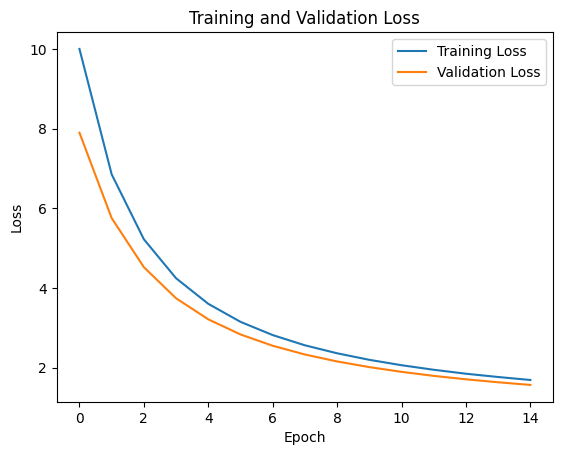

In [10]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_epochs = 15
learning_rate = 0.01

model = LogisticRegression(in_features=in_features, num_classes=num_classes)
optimizer = SGD(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()
metrics = {'accuracy':Accuracy()}
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Logistic Regression

Epoch 1/10, Training Loss: 2.0410, Validation Loss: 1.8559
Epoch 2/10, Training Loss: 1.8092, Validation Loss: 1.7536
Epoch 3/10, Training Loss: 1.7388, Validation Loss: 1.7060
Epoch 4/10, Training Loss: 1.6928, Validation Loss: 1.6637
Epoch 5/10, Training Loss: 1.6628, Validation Loss: 1.6434
Epoch 6/10, Training Loss: 1.6461, Validation Loss: 1.6308
Epoch 7/10, Training Loss: 1.6351, Validation Loss: 1.6220
Epoch 8/10, Training Loss: 1.6270, Validation Loss: 1.6150
Epoch 9/10, Training Loss: 1.6206, Validation Loss: 1.6097
Epoch 10/10, Training Loss: 1.6153, Validation Loss: 1.6052


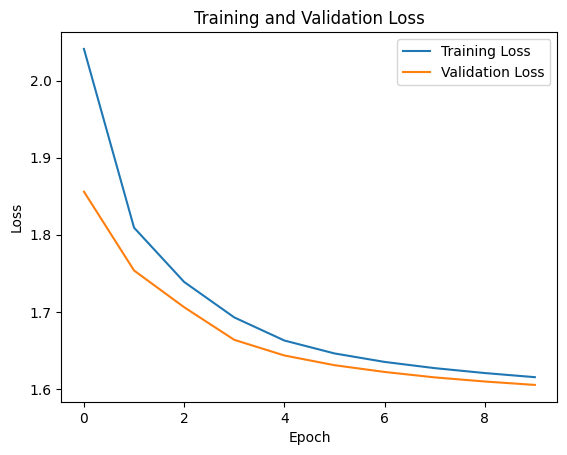

In [11]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)
        return out

model = LogisticRegression(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)